In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' 
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
dDataset = pd.read_excel('/content/BreastCancer_Prognostic_v1.xlsx',header=0)
dDataset = dDataset.loc[dDataset['Outcome'] == 'R']
print(dDataset.shape)

(47, 35)


In [0]:
dDataset = dDataset.replace('?', np.nan)
dDataset.fillna(dDataset.mean)
dDataset['Lymph_Node_Status']= dDataset['Lymph_Node_Status'].astype(float)

In [0]:
# dropping columns with correlation > 95%
dropped_columns = ['perimeter_mean', 'area_mean', 'Worst_radius','Worst_perimeter','Worst_area', "perimeter_std_dev", "area_std_dev"]
dDataset= dDataset.drop(dropped_columns, axis=1)

In [0]:
Y = dDataset['Time']

In [0]:
dDataset.head()

,ID,Outcome,Time,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_std_dev,texture_std_dev,smoothness_std_dev,compactness_std_dev,concavity_std_dev,concave_points_std_dev,symmetry_std_dev,fractal_dimension_std_dev,Worst_texture,Worst_smoothness,Worst_compactness,Worst_concavity,Worst_concave_points,Worst_symmetry,Worst_fractal_dimension,Tumor_Size,Lymph_Node_Status
4,843584,R,27,20.29,14.34,0.1003,0.1328,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,16.67,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0.0
5,843786,R,77,12.75,15.29,0.1189,0.1569,0.16640,0.07666,0.1995,0.07164,0.3877,0.7402,0.007775,0.02987,0.04561,0.01357,0.01774,0.005114,20.37,0.1706,0.4196,0.5999,0.1709,0.3485,0.11790,2.5,0.0
7,844582,R,77,13.71,20.83,0.1189,0.1645,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,28.14,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,4.0,10.0
13,847990,R,36,14.54,27.54,0.1139,0.1595,0.16390,0.07364,0.2303,0.07077,0.3700,1.0330,0.005607,0.04240,0.04741,0.01090,0.01857,0.005466,37.13,0.1678,0.6577,0.7026,0.1712,0.4218,0.13410,6.0,6.0
15,848620,R,10,16.13,20.68,0.1170,0.2022,0.17220,0.10280,0.2164,0.07356,0.5692,1.0730,0.007026,0.02501,0.03188,0.01297,0.01689,0.004142,31.48,0.1789,0.4233,0.4784,0.2073,0.3706,0.11420,3.0,1.0


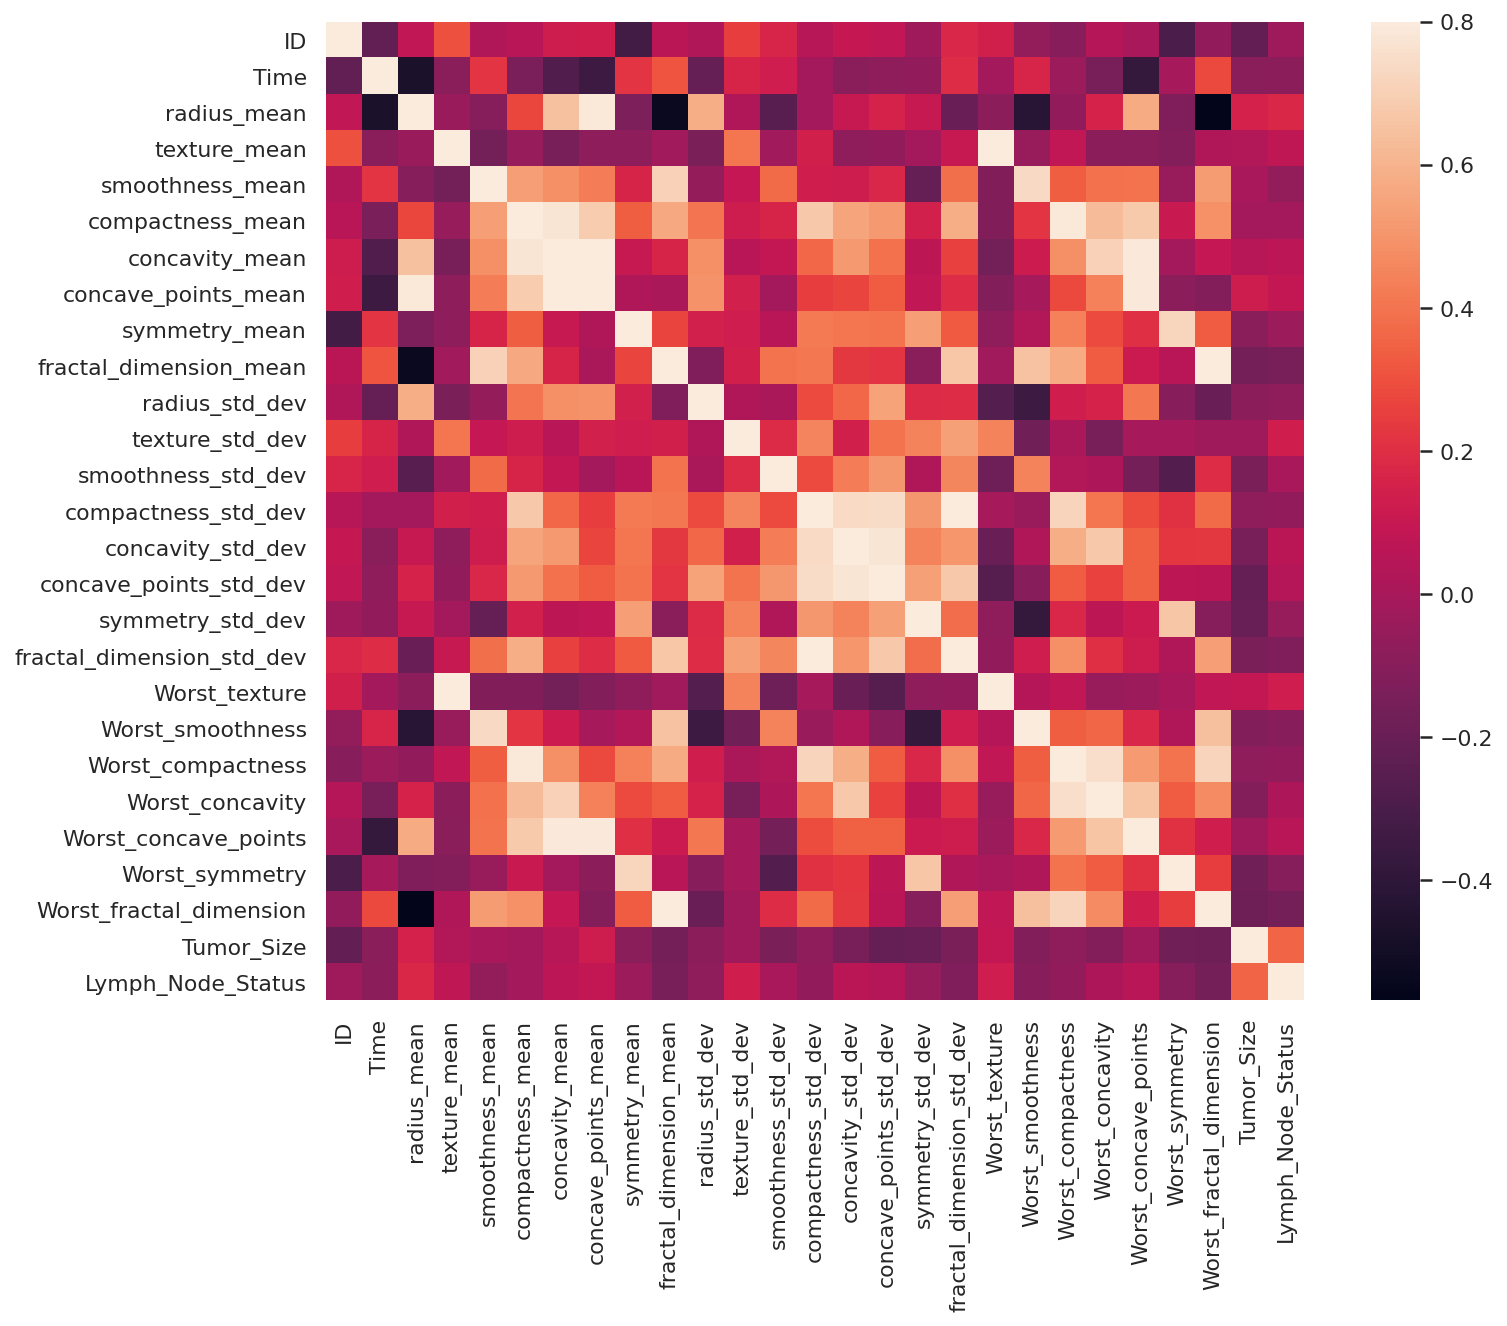

In [0]:
corrmat = dDataset.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

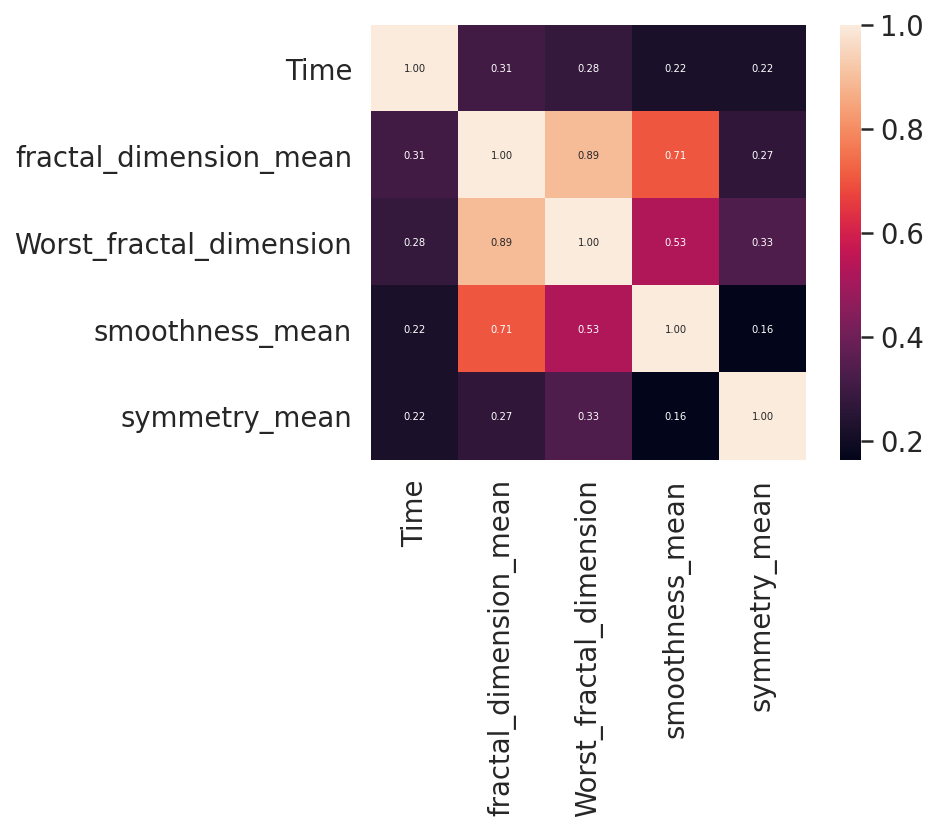

In [0]:
# Top 15 Heatmap
k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Time')['Time'].index
cm = np.corrcoef(dDataset[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 5}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [0]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,Time
1,fractal_dimension_mean
2,Worst_fractal_dimension
3,smoothness_mean
4,symmetry_mean


In [0]:
X = dDataset[['fractal_dimension_mean','Worst_fractal_dimension', 'smoothness_mean','symmetry_mean', 'fractal_dimension_std_dev']]
# 'Worst_smoothness','texture_std_dev','smoothness_std_dev','Worst_symmetry']]
# , 'compactness_std_dev']]
dDataset.head()

,ID,Outcome,Time,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_std_dev,texture_std_dev,smoothness_std_dev,compactness_std_dev,concavity_std_dev,concave_points_std_dev,symmetry_std_dev,fractal_dimension_std_dev,Worst_texture,Worst_smoothness,Worst_compactness,Worst_concavity,Worst_concave_points,Worst_symmetry,Worst_fractal_dimension,Tumor_Size,Lymph_Node_Status
4,843584,R,27,20.29,14.34,0.1003,0.1328,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,16.67,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0.0
5,843786,R,77,12.75,15.29,0.1189,0.1569,0.16640,0.07666,0.1995,0.07164,0.3877,0.7402,0.007775,0.02987,0.04561,0.01357,0.01774,0.005114,20.37,0.1706,0.4196,0.5999,0.1709,0.3485,0.11790,2.5,0.0
7,844582,R,77,13.71,20.83,0.1189,0.1645,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,28.14,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,4.0,10.0
13,847990,R,36,14.54,27.54,0.1139,0.1595,0.16390,0.07364,0.2303,0.07077,0.3700,1.0330,0.005607,0.04240,0.04741,0.01090,0.01857,0.005466,37.13,0.1678,0.6577,0.7026,0.1712,0.4218,0.13410,6.0,6.0
15,848620,R,10,16.13,20.68,0.1170,0.2022,0.17220,0.10280,0.2164,0.07356,0.5692,1.0730,0.007026,0.02501,0.03188,0.01297,0.01689,0.004142,31.48,0.1789,0.4233,0.4784,0.2073,0.3706,0.11420,3.0,1.0


In [0]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20,random_state=16)

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [0]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators = 2000, criterion='mse',random_state=1, n_jobs=-1,max_features= 'sqrt',max_depth= 50,min_samples_leaf=2)
reg=reg.fit(X_train, Y_train)
feat=(reg.feature_importances_)
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)
print(feat)

[0.1708723  0.17746862 0.31317262 0.11022682 0.22825965]


In [0]:
from sklearn.metrics import mean_squared_error, r2_score
#Root_Mean_Square_Log_Error(RMSE) is accuracy criteria for this problem
print('RMSLE train: %.3f' % np.sqrt(mean_squared_error(np.log(Y_train + 1), np.log(y_train_pred + 1))))
print('RMSLE test: %.3f' % np.sqrt(mean_squared_error(np.log(Y_test + 1), np.log(y_test_pred + 1))))
print(r2_score(Y_test, y_test_pred))

RMSLE train: 0.665
RMSLE test: 0.743
0.5031008626321413


In [0]:
regression = pd.DataFrame()
regression['Values'] = Y_test
regression['predictions'] = y_test_pred
regression.to_csv('regressor.csv')